<a href="https://colab.research.google.com/github/Imartinezcuevas/k_brazos_MC_OL/blob/main/bandit_experiment_GreedyVsGPreferencias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo Epsilon-Greedy vs Gradiente de Preferencias en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de los algoritmos Epsilon-Greedy y Gradiente de Preferencias en un problema de k-armed bandit.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

# Introducción
En este estudio, nos enfocamos en comparar el rendimiento de Epsilon-Greedy y Gradiente de Preferencias, dos algoritmos que han mostrado resultados significativos. El algoritmo de Gradiente de Preferencias supera a la estrategia Softmax dentro de la familia de Ascenso del Gradiente. Si visitamos el notebook donde se hace la comparación, se observa que Softmax ni siquiera llega a la recompensa óptima.

El objetivo principal de este estudio es analizar y comparar el rendimiento de estos dos algoritmos bajo diversas condiciones experimentales. Para ello, se evaluará su desempeño mediante:

1. **Estudio individual de cada algoritmo**: Se analizará el impacto de la variación de parámetros clave, como la tasa de aprendizaje (α) en Gradiente de Preferencias y el parámetro de exploración en Epsilon-Greedy.

*Como ya hemos hecho el estudio individual en cada notebook correspondiente, pasaremos directamente al paso 2 con los parámetros que muestran mejores resultados.*

2. **Comparación directa entre Epsilon-Greedy y Gradiente de Preferencias**: Se seleccionarán los mejores parámetros de cada algoritmo y se comparará su rendimiento en entornos controlados.
3. **Estudio de la influencia de las distribuciones de recompensa**: Se modificarán las distribuciones subyacentes para analizar la robustez de cada enfoque.
4. **Evaluación con diferentes cantidades de brazos**: Se estudiará el efecto de aumentar o disminuir el número de brazos en la efectividad de cada algoritmo.

A través de estos experimentos, buscamos entender en qué escenarios cada algoritmo sobresale y proporcionar recomendaciones sobre su aplicabilidad en problemas reales de toma de decisiones secuenciales.

## Preparación del entorno

In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/k_brazos_MC_OL.git
!cd k_brazos_MC_OL/

fatal: destination path 'k_brazos_MC_OL' already exists and is not an empty directory.


In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy, GradientePreferencias
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_MC_OL/src']


## Bucle experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    # Para almacenar selecciones y recompensas promedio de cada brazo por algoritmo
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Número de selecciones por brazo
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Suma de recompensas por brazo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)
        # Obtener la recompensa esperada óptima.
        optimal_reward = current_bandit.get_expected_value(optimal_arm)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.
                regrets[idx, step] = optimal_reward*(step+1) - total_rewards_per_algo[idx] # Acumular el regret en la matriz regrets para el algoritmo idx en el paso step.


                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm",
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Registrar número de selecciones y recompensas por brazo
                arm_counts[idx, chosen_arm] += 1
                arm_rewards[idx, chosen_arm] += reward


    rewards /= runs
    regrets /= runs  # Calcular el promedio del regret acumulado
    arm_avg_rewards = np.divide(arm_rewards, arm_counts, out=np.zeros_like(arm_rewards), where=arm_counts != 0)
    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    return rewards, optimal_selections, regrets, arm_counts, arm_avg_rewards

# Análisis comparativo

### Comparación entre algoritmos
Las variantes a estudiar son las siguiente:
* Para Gradiente de Preferencias: alpha = {0.1, 0.3}
* Para Epsilon-Greedy: epsilon = 0.1

Cosas a estudiar:
* Velocidad de convergencia de cada algoritmo.
* Comparar la recompensa acumulada y regret alcanzados por cada uno.
* Observar la capacidad de cada algoritmo para identificar y seleccionar el brazo óptimo.

In [4]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### Recompensa promedio

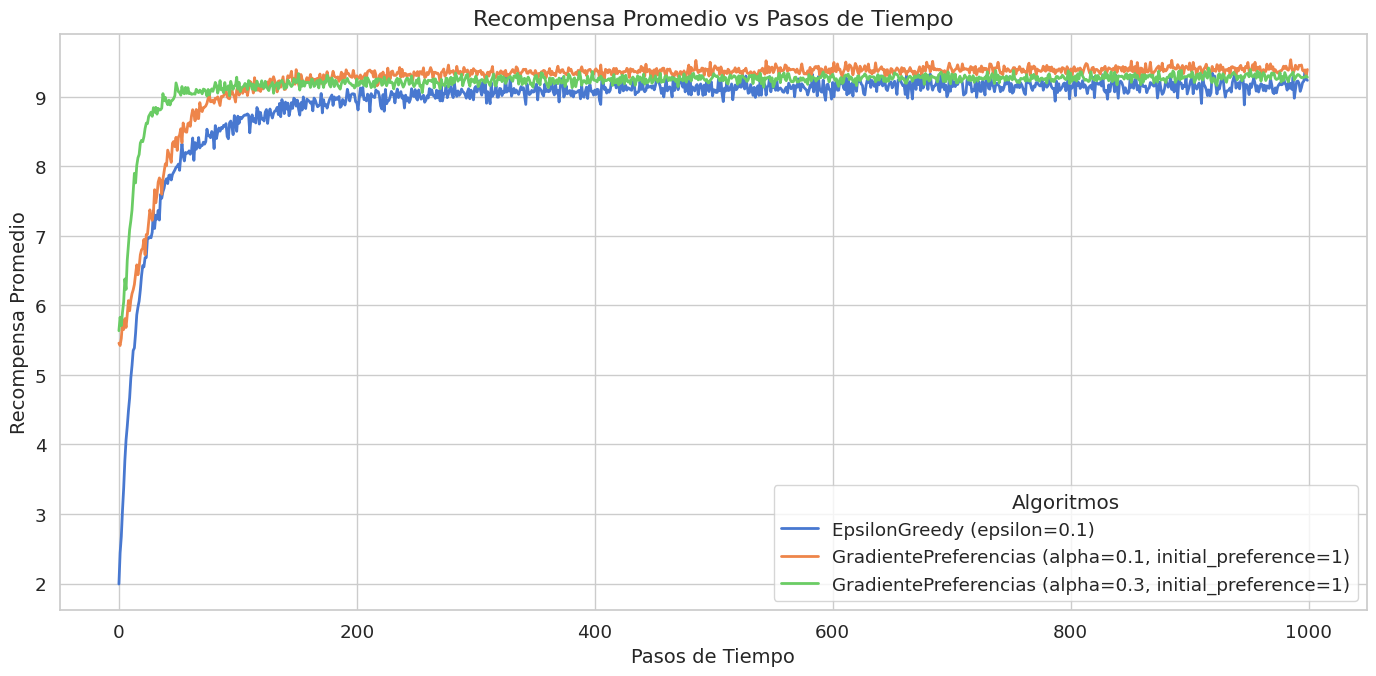

In [5]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
1. **Epsilon-Greedy:**

  * Tarda más en converger  que las variantes de Gradiente de Preferencias.
  * Alcanza una recompensa promedio ligeramente inferior a la óptima y las otras variantes.

2. **Gradiente de Preferencias (α = 0.1 y α = 0.3):**

  * La línea verde (α=0.3) alcanza rápidamente una recompensa alta, similar a Epsilon-Greedy.
  * La línea naranja (α=0.1) muestra un crecimiento algo más lento, pero alcanza la recompensa promedio más alta.

**Conclusiones**
  * Gradiente de Preferencias tiene un buen desempeño, alcanzando rápidamente recompensas altas.
  * El método de Epsilon-Greedy es más lento en aprender.
  * Todos los algoritmos convergen hacia una recompensa promedio alta, pero algunos tardan más en llegar.

#### Regret acumulado

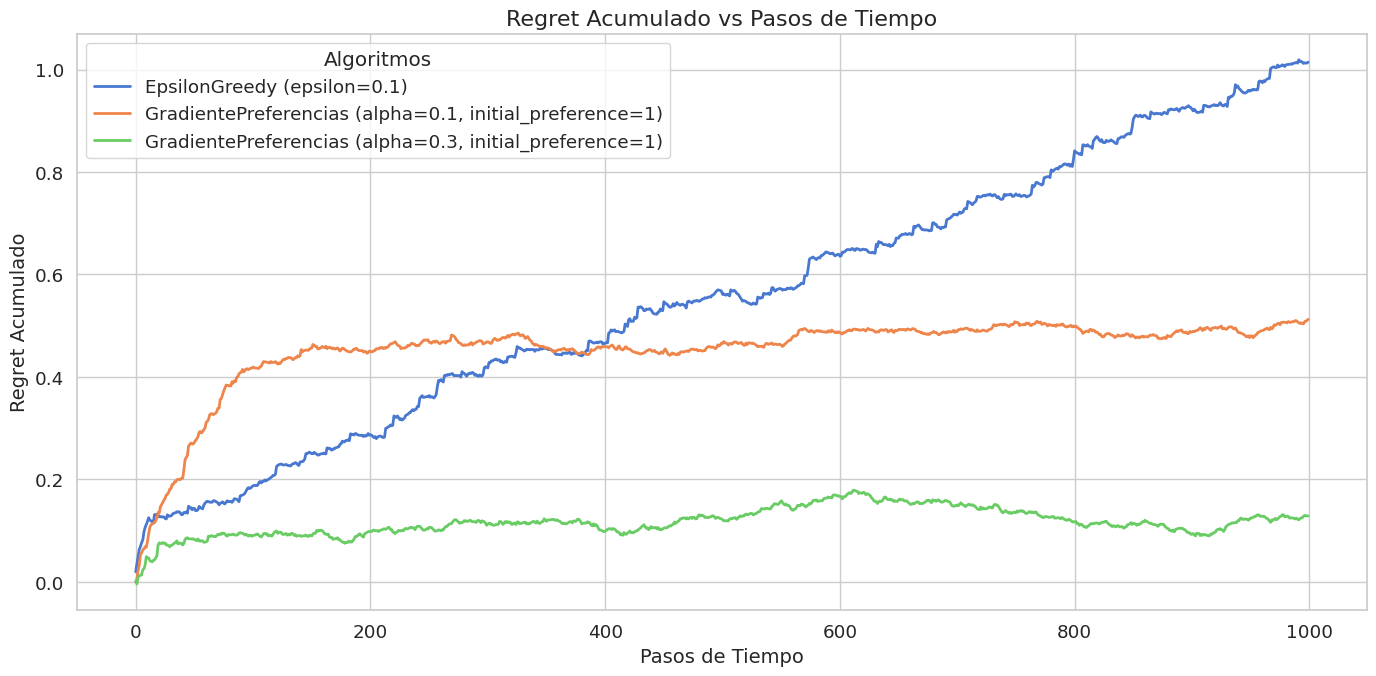

In [6]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Las dos variante de Gradiente de Preferencias obtienen muy buenos resultados.
  * Epsilon-Greedy crece a un ritmo mucho más rapido. Como veremos en la gráfica siguiente, es el que más selecciona el brazo óptimo. Sin embargo, las veces que no lo selecciones, probablemente seleccione un brazo con muy poca recompensa.

**Conclusiones**
  * El mejor algoritmo es Gradiente de Preferencias en cuanto al regret acumulado.
  * El que tiene alpha más alto es el que obtiene menos regret acumulado.

#### Porcentaje de selección del brazo óptimo

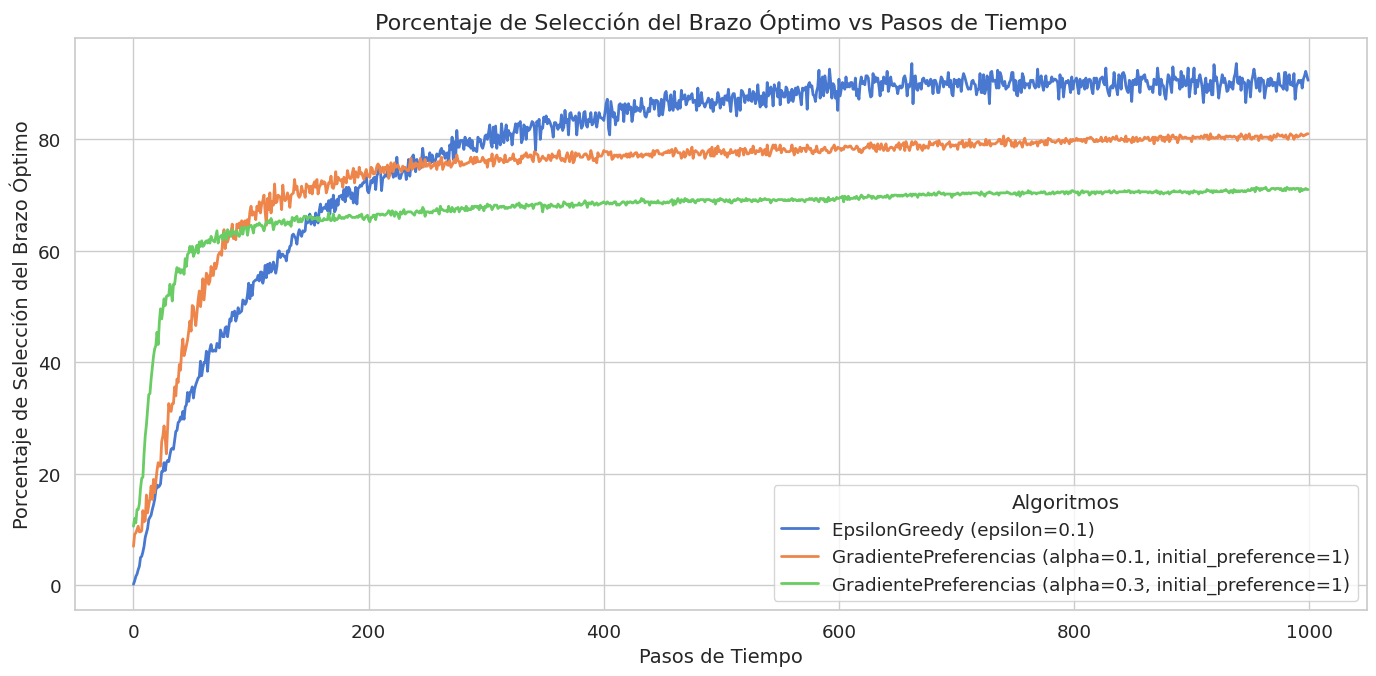

In [7]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
* Igual que antes, Epsilon-Greedy es el que tarda más en converger. Pero lo hace a un mayor porcentaje.
* Gradiente de Preferencias es algo más rapido, pero a menores porcentajes.

**Conclusiones**
* Nos quedaríamos con Gradiente de Preferencias porque, aunque elige menos veces el brazo óptimo, los demás brazos que elige tienen una recompensa simililar.
* Mientras que epsilon-greedy cuando no elige el brazo óptimo, elige uno aleatorio. Dando lugar a una recompensa promedio más baja y a un regret acumulado más alto.

## Comparación entre número de brazos
Para comparar los algoritmos en escenarios con diferentes niveles de complejidad. Para ello en este apartado se estudiará como el número de brazos afecta en la capacidad de convergencia y la eficiencia de ambos algoritmos.

Los objetivos son:
* Determinar como el rendimiento de los algoritmos se ve afectado al aumentar el número de brazos.
* Observar como la velocidad de convergencia varía en función del número de brazos.

Se realizarán experimentos variando el número de brazos en el siguiente rango $[10, 30]$.

#### K = 20

In [8]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 20  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 20 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

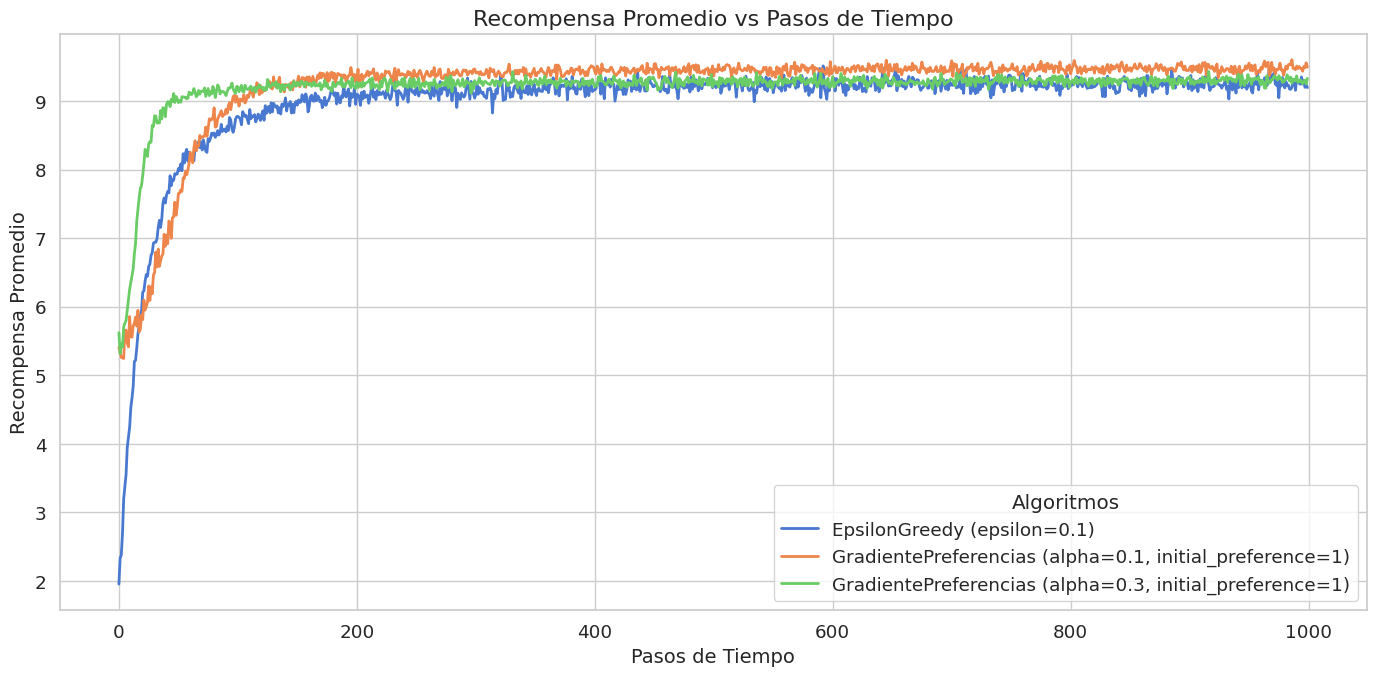

In [9]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
 * La principal diferencia es un ligero incremento en los pasos de tiempo necesarios para converger.
 * La línea verde (α=0.3) alcanza rápidamente una recompensa alta, similar a Epsilon-Greedy.
 * La línea naranja (α=0.1) muestra un crecimiento algo más lento, pero alcanza la recompensa promedio más alta.

**Conclusiones**
  * Aumentar el número de brazos no influye en la recompensa promedio obtenida.

##### Regret acumulado

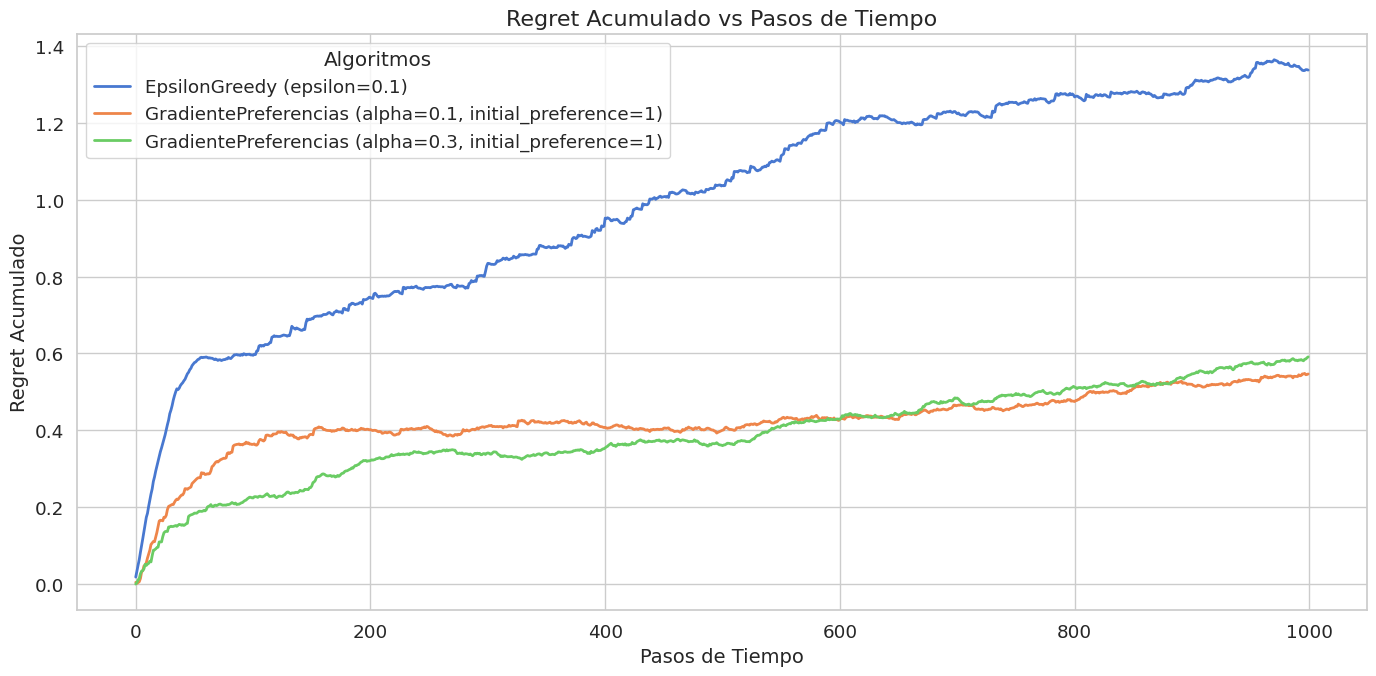

In [10]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Puesto que hay más brazos, la fase de exploración se hace un poco más larga y, en consecuencia, aumenta el regret acumulado.

**Conclusiones**
  * El mejor algoritmo es Gradiente de Preferencias en cuanto al regret acumulado.
  * El que tiene alpha más alto es el que obtiene menos regret acumulado.

##### Porcentaje de selección del brazo óptimo

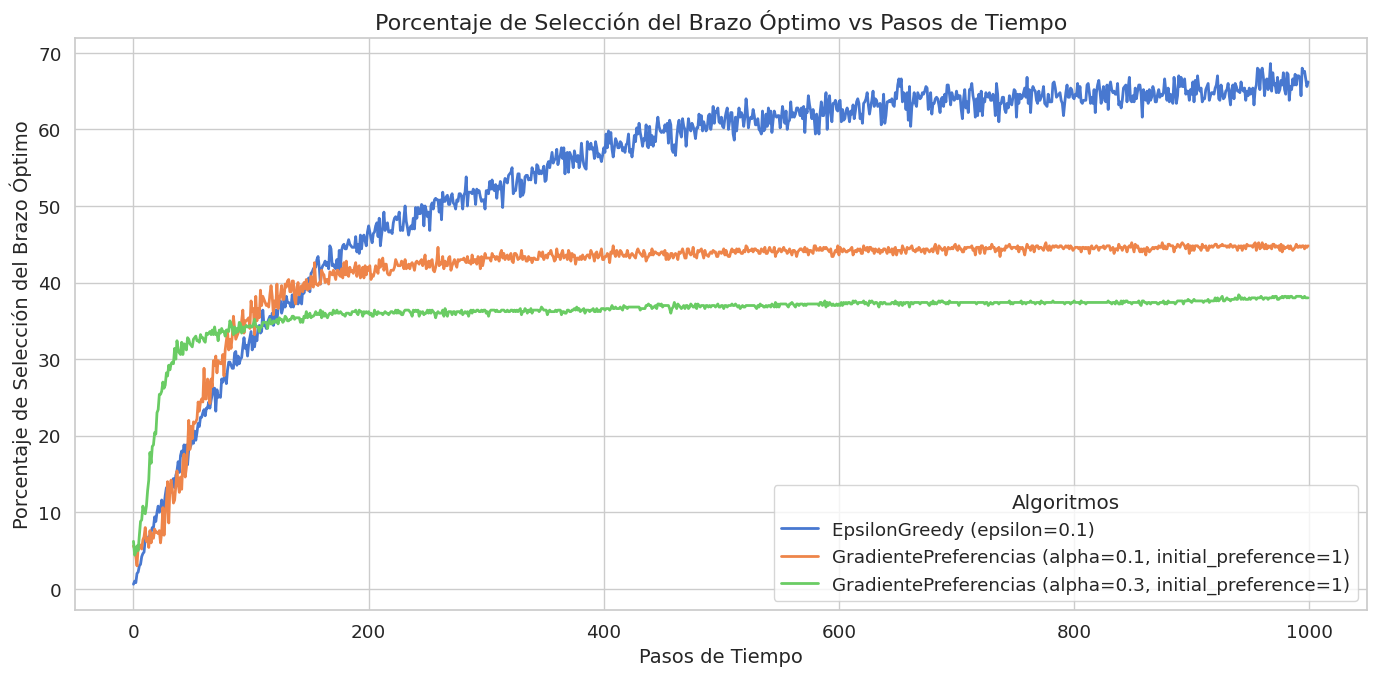

In [11]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
* Igual que antes, Epsilon-Greedy es el que tarda más en converger. Lo hace a un porcentaje similar pero tarda muchas más iteraciones.
* Gradiente de Preferencias es algo más rapido, pero a menores porcentajes.
* Vemos una reducción de casi un 30% en la selección del brazo óptimo.

**Conclusiones**
* Nos quedaríamos con Gradiente de Preferencias porque, aunque elige menos veces el brazo óptimo, los demás brazos que elige tienen una recompensa simililar.
* Mientras que epsilon-greedy cuando no elige el brazo óptimo, elige uno aleatorio. Dando lugar a una recompensa promedio más baja y a un regret acumulado más alto.

#### K = 30

In [12]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 30  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 30 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=2.26, sigma=1.0), ArmNormal(mu=5.1, sigma=1.0), ArmNormal(mu=6.33, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=2.8, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=3.63, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=4.3, sigma=1.0), ArmNormal(mu=5.63, sigma=1.0), ArmNormal(mu=6.47, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0), ArmNormal(mu=1.42, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

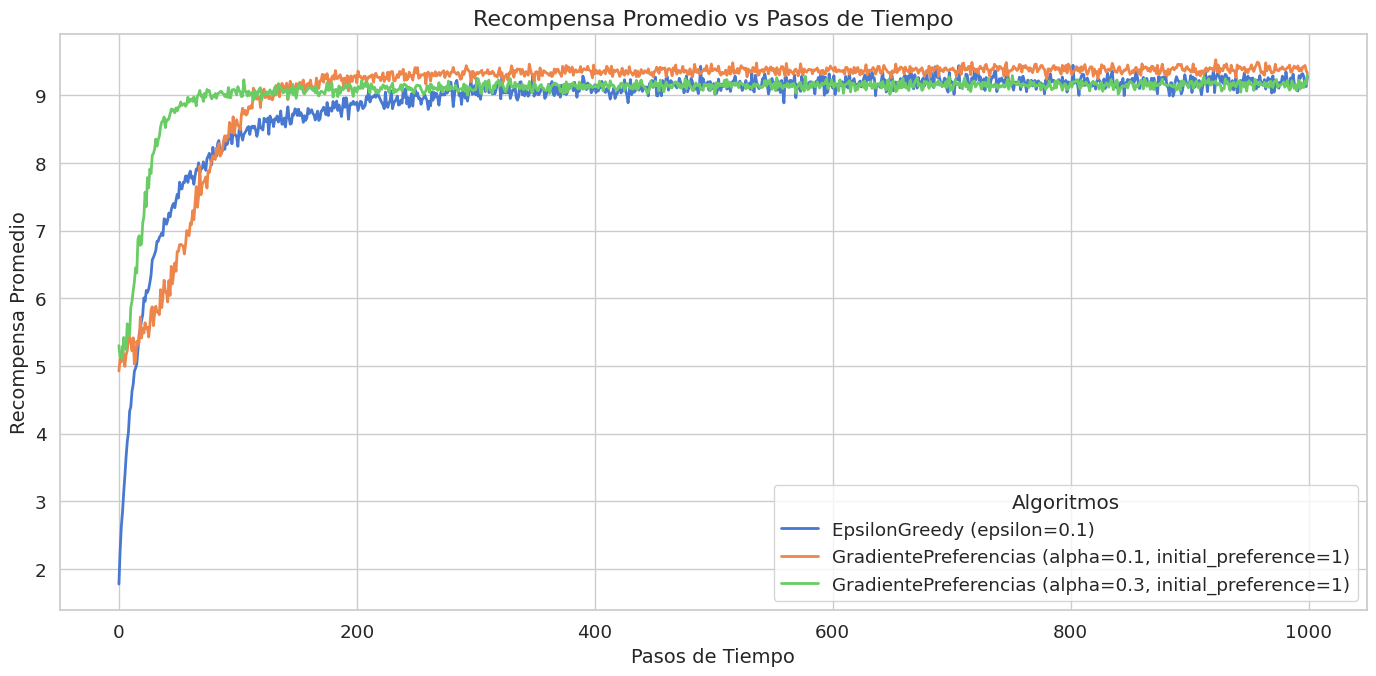

In [13]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
 * En esta imagen si que podemos apreciar que se tardan más pasos de tiempo en converger.

**Conclusiones**
  * Aumentar el número de brazos no influye mucho en la recompensa promedio obtenida.

##### Regret acumulado

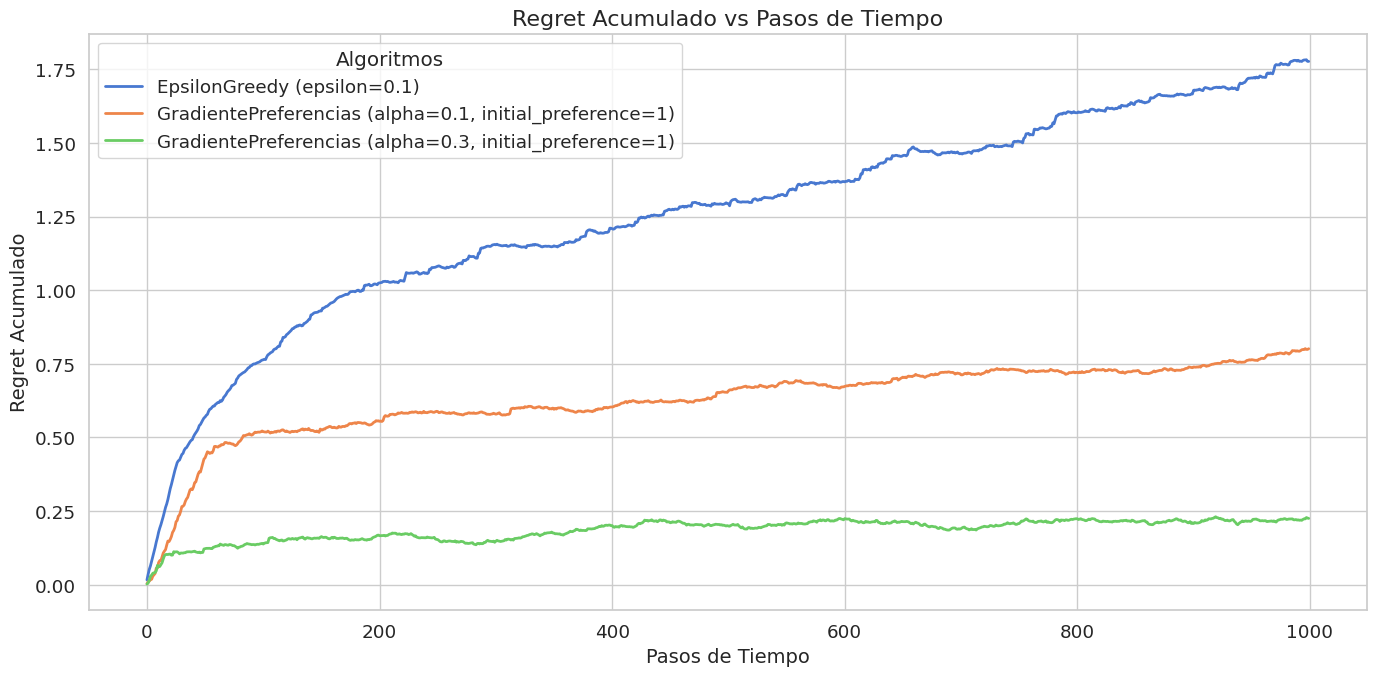

In [14]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Puesto que hay más brazos, la fase de exploración se hace un poco más larga y, en consecuencia, aumenta el regret acumulado.

**Conclusiones**
  * El mejor algoritmo es Gradiente de Preferencias en cuanto al regret acumulado.
  * El que tiene alpha más alto es el que obtiene menos regret acumulado.

##### Porcentaje de selección del brazo óptimo

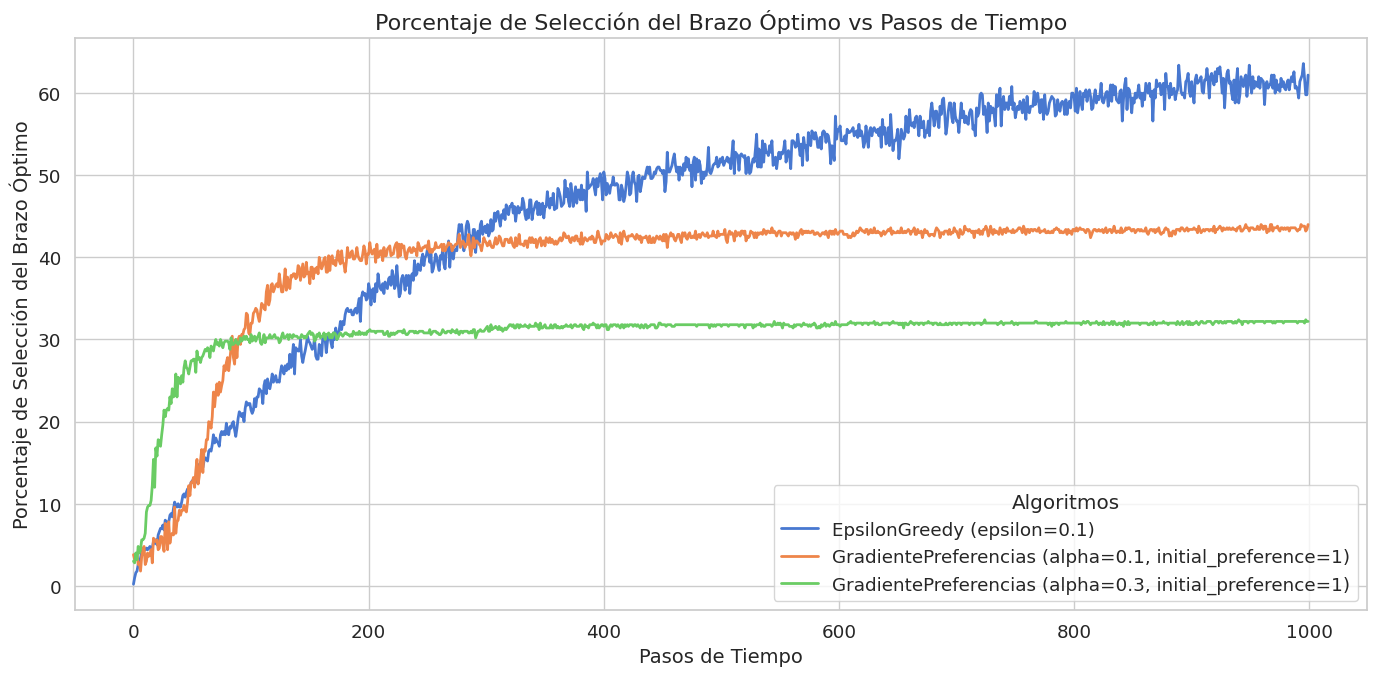

In [15]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
* Igual que antes, Epsilon-Greedy es el que tarda más en converger. Lo hace a un porcentaje similar pero tarda muchas más iteraciones.
* Gradiente de Preferencias es algo más rapido, pero a menores porcentajes.
* Vemos una reducción de casi un 30% en la selección del brazo óptimo.

**Conclusiones**
* Nos quedaríamos con Gradiente de Preferencias porque, aunque elige menos veces el brazo óptimo, los demás brazos que elige tienen una recompensa simililar.
* Mientras que epsilon-greedy cuando no elige el brazo óptimo, elige uno aleatorio. Dando lugar a una recompensa promedio más baja y a un regret acumulado más alto.

## Comparación entre distribuciones
El paso final es analizar su comportamiento ante diferentes distribuciones de recompensa.

No se va a analizar la distribución normal ya que saldrían las mismas graficas que obtenidas en el apartado "Comparación entre algoritmos".

#### Distribución binomial

In [16]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k, 10)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=10, p=0.4), ArmBinomial(n=10, p=0.86), ArmBinomial(n=10, p=0.22), ArmBinomial(n=10, p=0.69), ArmBinomial(n=10, p=0.58), ArmBinomial(n=10, p=0.15), ArmBinomial(n=10, p=0.79), ArmBinomial(n=10, p=0.67), ArmBinomial(n=10, p=0.12), ArmBinomial(n=10, p=0.88)
Optimal arm: 10 with expected reward=8.8


##### Recompensa promedio

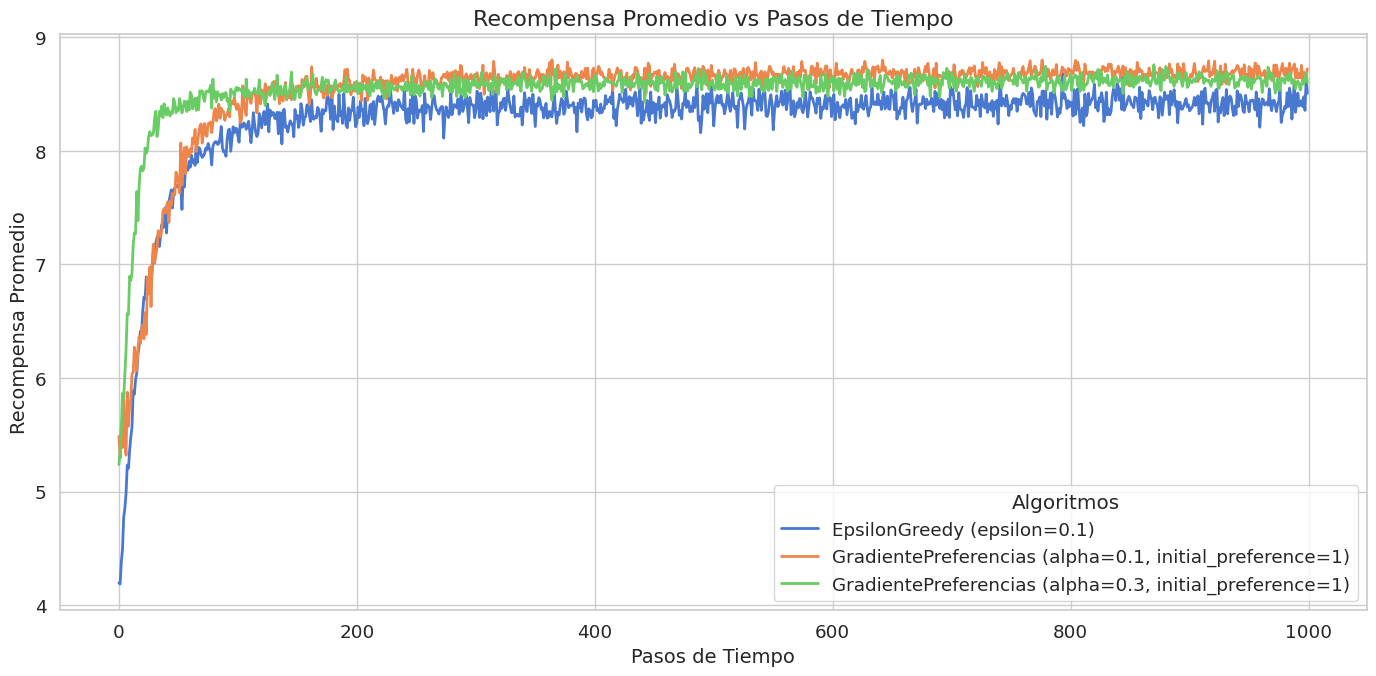

In [17]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
1. **Epsilon-Greedy:**

  * Tarda más en converger  que las variantes de Gradiente de Preferencias.
  * Alcanza una recompensa promedio ligeramente inferior a la óptima y las otras variantes.

2. **Gradiente de Preferencias (α = 0.1 y α = 0.3):**

  * La línea verde (α=0.3) alcanza rápidamente una recompensa alta, similar a Epsilon-Greedy.
  * La línea naranja (α=0.1) muestra un crecimiento algo más lento, pero alcanza la recompensa promedio más alta.

**Conclusiones**
  * Gradiente de Preferencias tiene un buen desempeño, alcanzando rápidamente recompensas altas.
  * El método de Epsilon-Greedy es más lento en aprender.
  * Todos los algoritmos convergen hacia una recompensa promedio alta, pero algunos tardan más en llegar.

##### Regret acumulado

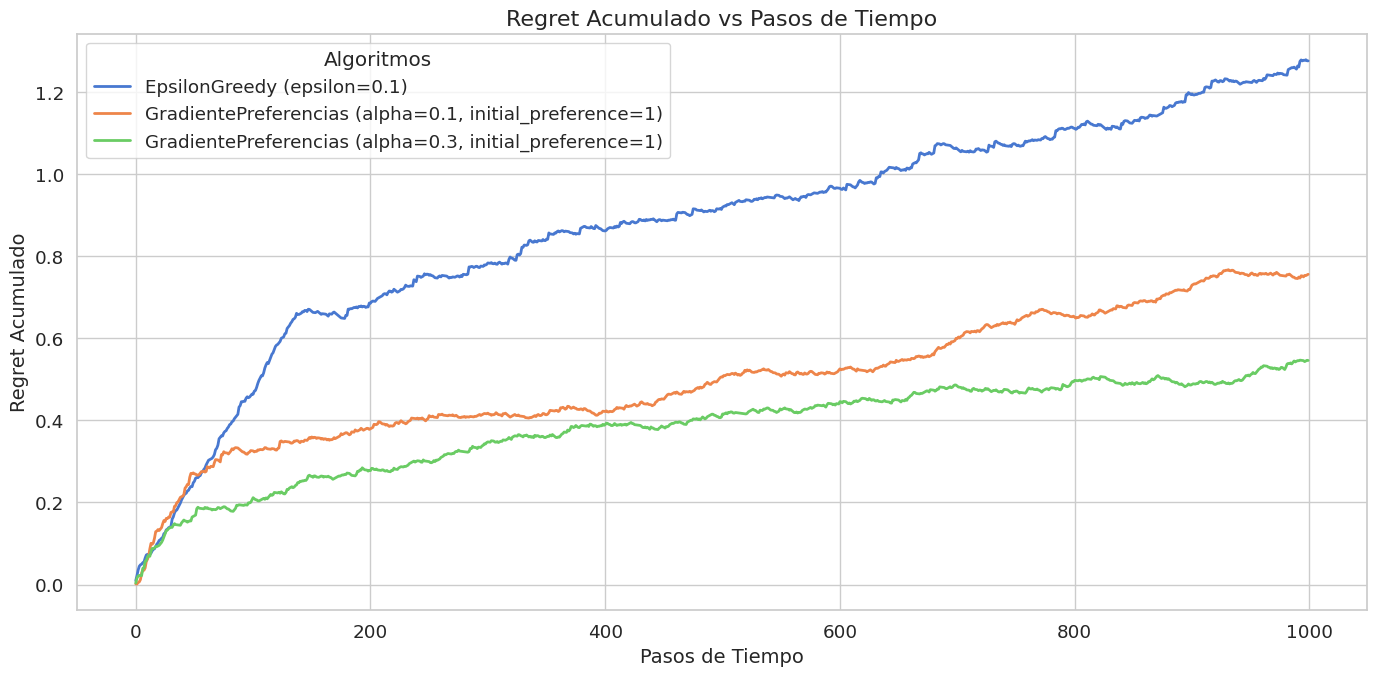

In [18]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Las dos variante de Gradiente de Preferencias obtienen muy buenos resultados.
  * Epsilon-Greedy crece a un ritmo mucho más rapido. Como veremos en la gráfica siguiente, es el que más selecciona el brazo óptimo. Sin embargo, las veces que no lo selecciones, probablemente seleccione un brazo con muy poca recompensa.
  * Se observa que las curvas para Gradiente de Preferencias tienen una mayor pendiente que con la distribución normal.

**Conclusiones**
  * El mejor algoritmo es Gradiente de Preferencias en cuanto al regret acumulado.
  * El que tiene alpha más alto es el que obtiene menos regret acumulado.

##### Porcentaje de selección del brazo óptimo

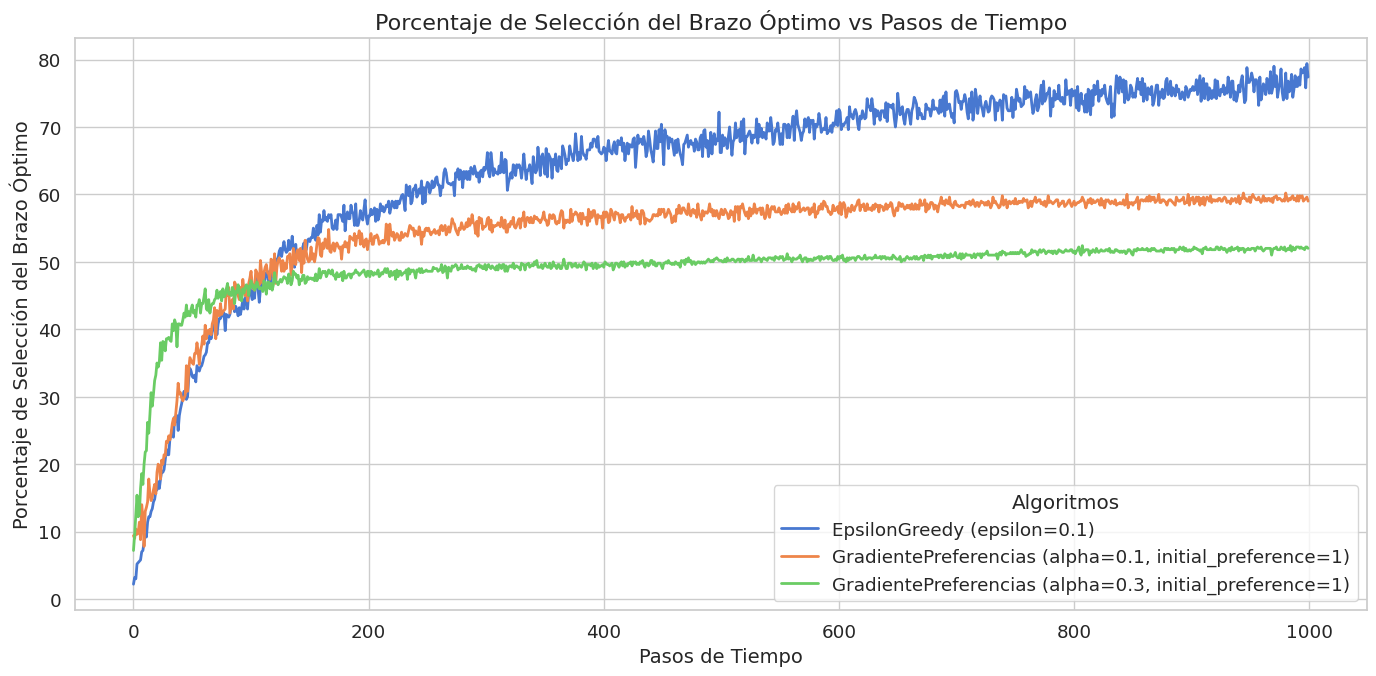

In [19]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
* Igual que antes, Epsilon-Greedy es el que tarda más en converger. Pero lo hace a un mayor porcentaje.
* Gradiente de Preferencias es algo más rapido, pero a menores porcentajes.

**Conclusiones**
* Nos quedaríamos con Gradiente de Preferencias porque, aunque elige menos veces el brazo óptimo, los demás brazos que elige tienen una recompensa simililar.
* Mientras que epsilon-greedy cuando no elige el brazo óptimo, elige uno aleatorio. Dando lugar a una recompensa promedio más baja y a un regret acumulado más alto.

#### Distribución de Bernoulli

In [20]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.4), ArmBernoulli(p=0.86), ArmBernoulli(p=0.22), ArmBernoulli(p=0.69), ArmBernoulli(p=0.58), ArmBernoulli(p=0.15), ArmBernoulli(p=0.79), ArmBernoulli(p=0.67), ArmBernoulli(p=0.12), ArmBernoulli(p=0.88)
Optimal arm: 10 with expected reward=0.88


##### Recompensa promedio

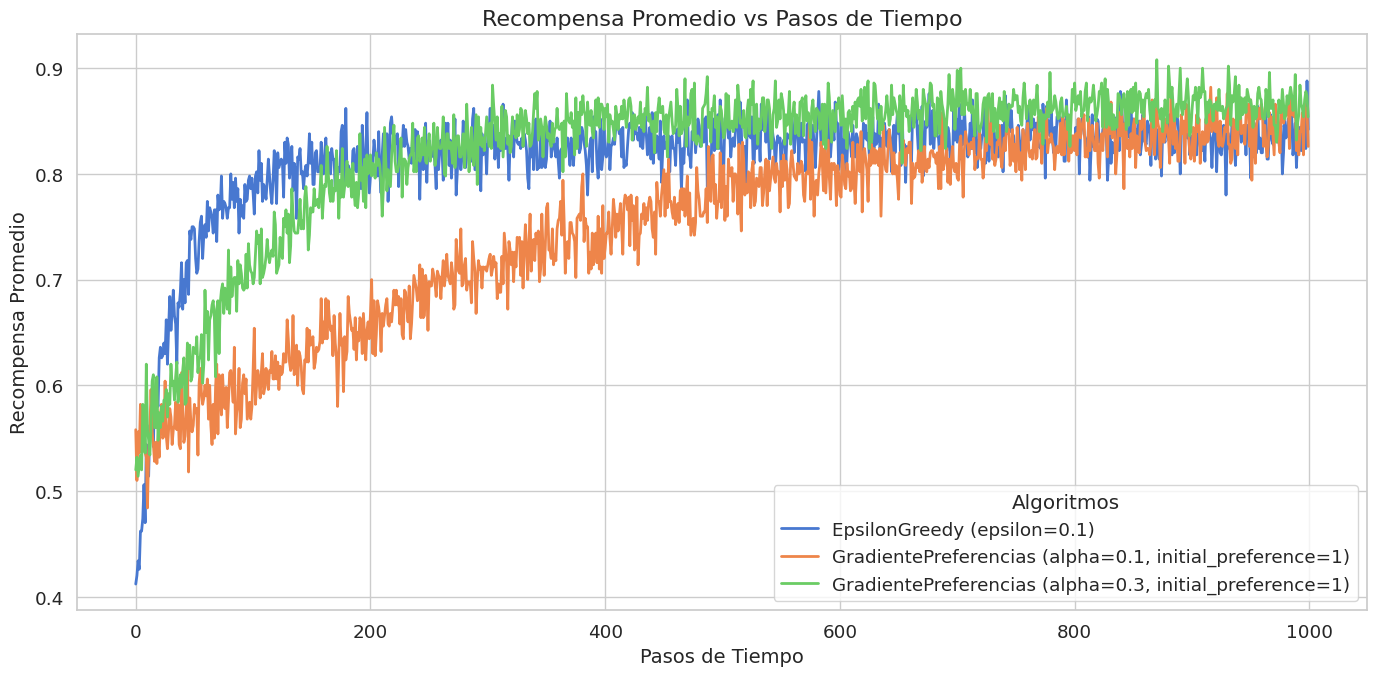

In [21]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
1. **Epsilon-Greedy:**

  * Justo al contrario que con las otras distribuciones, epsilon-greedy es la que más rapido converge.

2. **Gradiente de Preferencias (α = 0.1 y α = 0.3):**

  * La línea verde (α=0.3) alcanza rápidamente una recompensa alta, similar a Epsilon-Greedy.
  * La línea naranja (α=0.1) muestra un crecimiento algo más lento, pero alcanza la recompensa promedio más alta.

**Conclusiones**
  * Gradiente de Preferencias tiene un buen desempeño, alcanzando rápidamente recompensas altas.
  * El método de Epsilon-Greedy es más lento en aprender.
  * Todos los algoritmos convergen hacia una recompensa promedio alta, pero algunos tardan más en llegar.

##### Regret acumulado

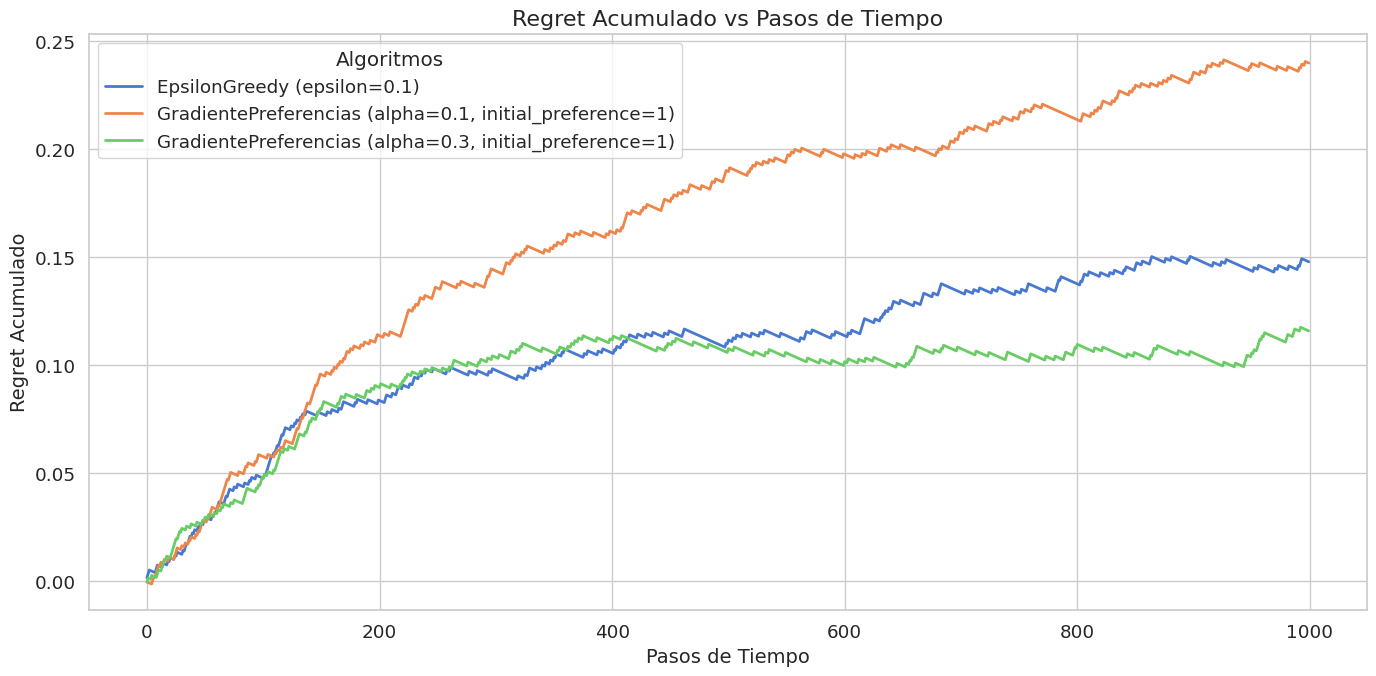

In [22]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Epsilon-Greedy no crece a un ritmo linear. Su curva se parece bastante más a las de las variantes de Gradiente de Preferencias.
  * La peor es la variante de Gradiente de Preferencias con alpha=0.1.

**Conclusiones**
  * Para esta distribución epsilon-Greedy obtiene muy buenos resultados.
  * Sin embargo, la variante con alpha=0.3 de Gradiente de Preferencias sigue siendo la mejor.

##### Porcentaje de selección del brazo óptimo

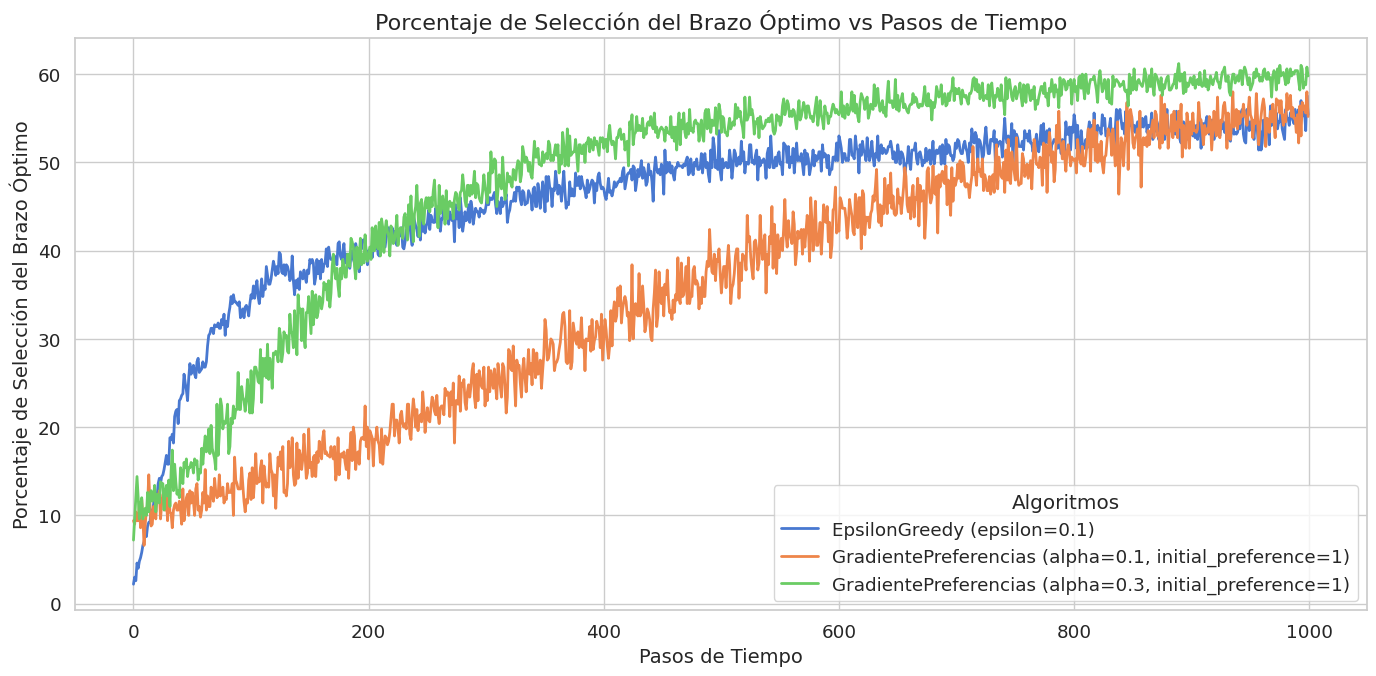

In [23]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos Epsilon-Greedy y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
* Aquí podemos ver el por qué de los resultados tan buenos de epsilon-greedy. Tarda muy poco en converger a seleccionar el brazo óptimo un 50% de las veces.
Es el que más rápido converge.
* La variante con alpha=0.1 sigue siendo más lenta al converger que la variante con alpha=0.3.

**Conclusiones**
* Nos quedaríamos con Gradiente de Preferencias porque elige más veces el brazo óptimo. Y además, no tarda tanto en converger como la variante de alpha 0.3.
